In [1]:
import time

import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax

In [2]:
class Func(eqx.Module):
    mlp: eqx.nn.MLP

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.mlp = eqx.nn.MLP(
            in_size=data_size,
            out_size=data_size,
            width_size=width_size,
            depth=depth,
            activation=jnn.softplus,
            key=key,
        )

    def __call__(self, t, y, args):
        return self.mlp(y)

In [3]:
class NeuralODE(eqx.Module):
    func: Func

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.func = Func(data_size, width_size, depth, key=key)

    def __call__(self, ts, y0):
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.func),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=diffrax.SaveAt(ts=ts),
        )
        return solution.ys


In [5]:
def _get_data(ts, *, key):
    y0 = jrandom.uniform(key, (2,), minval=-0.6, maxval=1)

    def f(t, y, args):
        x = y / (1 + y)
        return jnp.stack([x[1], -x[0]], axis=-1)

    solver = diffrax.Tsit5()
    dt0 = 0.1
    saveat = diffrax.SaveAt(ts=ts)
    sol = diffrax.diffeqsolve(
        diffrax.ODETerm(f), solver, ts[0], ts[-1], dt0, y0, saveat=saveat
    )
    ys = sol.ys
    return ys


def get_data(dataset_size, *, key):
    ts = jnp.linspace(0, 10, 100)
    key = jrandom.split(key, dataset_size)
    ys = jax.vmap(lambda key: _get_data(ts, key=key))(key)
    return ts, ys

In [6]:
def dataloader(arrays, batch_size, *, key):
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = jnp.arange(dataset_size)
    while True:
        perm = jrandom.permutation(key, indices)
        (key,) = jrandom.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size

In [12]:
def main(
    dataset_size=256,
    batch_size=32,
    lr_strategy=(3e-3, 3e-3),
    steps_strategy=(500, 500),
    length_strategy=(0.1, 1),
    width_size=64,
    depth=2,
    seed=5678,
    plot=True,
    print_every=100,
):
    key = jrandom.PRNGKey(seed)
    data_key, model_key, loader_key = jrandom.split(key, 3)

    ts, ys = get_data(dataset_size, key=data_key)
    _, length_size, data_size = ys.shape

    model = NeuralODE(data_size, width_size, depth, key=model_key)

    # Training loop like normal.
    #
    # Only thing to notice is that up until step 500 we train on only the first 10% of
    # each time series. This is a standard trick to avoid getting caught in a local
    # minimum.

    @eqx.filter_value_and_grad
    def grad_loss(model, ti, yi):
        y_pred = jax.vmap(model, in_axes=(None, 0))(ti, yi[:, 0])
        return jnp.mean((yi - y_pred) ** 2)

    @eqx.filter_jit
    def make_step(ti, yi, model, opt_state):
        loss, grads = grad_loss(model, ti, yi)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state

    for lr, steps, length in zip(lr_strategy, steps_strategy, length_strategy):
        optim = optax.adabelief(lr)
        opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))
        _ts = ts[: int(length_size * length)]
        _ys = ys[:, : int(length_size * length)]
        for step, (yi,) in zip(
            range(steps), dataloader((_ys,), batch_size, key=loader_key)
        ):
            start = time.time()
            loss, model, opt_state = make_step(_ts, yi, model, opt_state)
            end = time.time()
            if (step % print_every) == 0 or step == steps - 1:
                print(f"Step: {step}, Loss: {loss}, Computation time: {end - start}")

    if plot:
        plt.plot(ts, ys[0, :, 0], c="dodgerblue", label="Real")
        plt.plot(ts, ys[0, :, 1], c="green")
        model_y = model(ts, ys[0, 0])
        plt.plot(ts, model_y[:, 0], c="crimson", label="Model")
        plt.plot(ts, model_y[:, 1], c="crimson")
        plt.legend()
        plt.tight_layout()
        plt.savefig("neural_ode.png")
        plt.show()

    return ts, ys, model


Step: 0, Loss: 0.1665748655796051, Computation time: 19.58526110649109
Step: 100, Loss: 0.011155596002936363, Computation time: 0.008646011352539062
Step: 200, Loss: 0.006481669377535582, Computation time: 0.008472681045532227
Step: 300, Loss: 0.0013826749054715037, Computation time: 0.0093231201171875
Step: 400, Loss: 0.0010729273781180382, Computation time: 0.00976109504699707
Step: 499, Loss: 0.0007999555091373622, Computation time: 0.010484933853149414
Step: 0, Loss: 0.02832135185599327, Computation time: 21.75308394432068
Step: 100, Loss: 0.005405452102422714, Computation time: 0.029925823211669922
Step: 200, Loss: 0.004349536262452602, Computation time: 0.032351016998291016
Step: 300, Loss: 0.0018012302462011576, Computation time: 0.03130698204040527
Step: 400, Loss: 0.0017832081066444516, Computation time: 0.031333208084106445
Step: 499, Loss: 0.0011792700970545411, Computation time: 0.03128194808959961


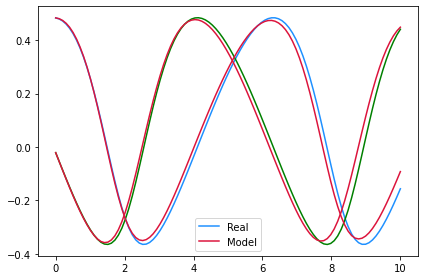

In [13]:
ts, ys, model = main()